# Evoluční algoritmy - spojitá a kombinatorická optimalizace

Minule jsme si ukazovali jednoduchý genetický algoritmus, který pracoval s binárními jedinci. Dnes se podíváme na spojité a celočíselné reprezentace jedinců a na další druhy evolučních operátorů.

## Minimalizace Rastrigin funkce

V následujícím cvičení si vyzkoušíme napsat jednoduchý evoluční algoritmus pro minimalizace [Rastrigin funkce](https://en.wikipedia.org/wiki/Rastrigin_function). Tato funkce je typickým příkladem nelineární funkce a běžně se používá při testování chování optimalizačních algoritmů. Nalezení jejího globálního minima je složité, protože obsahuje spoustu lokálních minim. Globální minimum se nachází v bodě 0.

In [1]:
import numpy as np
import random
import copy
import math
%matplotlib inline
import matplotlib.pyplot as plt

Nejprve si definujem, jak tedy vypadá ona výše zmíněná funkce, kterou budeme chtít minimalizovat a naimplementujeme podle toho fitness. Hodnota fitness je vlastně hodnota rastrigin funkce v daném bodě, který jedinec reprezentuje. Protože evoluční algoritmus je maximalizační algoritmus, obrátíme znaménko u výsledné hodnoty funkce.

In [2]:
def fitness(individual):
    N = len(individual)
    A = 10
    value = A*N
    for i in range(0,len(individual)):
        value += individual[i]**2 - A*math.cos(2*math.pi*individual[i])
    return -value

Potom je třeba si rozmyslet, jak bude vypadat jedinec. Bude to bude floating point vektor, kde hodnoty budou čísla z intervalu [-5.12,5.12] podle definičního oboru rastrigin funkce. Napíšeme si tedy funkci na vytvoření náhodné populace.

In [3]:
def random_population(population_size, individual_size):
    population = []
    
    for i in range(0,population_size):
        individual = np.random.uniform(-5.12, 5.12, size=(individual_size,))
        population.append(individual)
        
    return population

Pro vytvořenou populaci jedinců si napíšeme svoje operátory křížení a mutace. Křížení může být aritmetické, například vážený průměr dvou jedinců, nebo strukturální, kdy opět prohazujeme části jedinců. Zde si zkusíme naimplementovat aritmetické křížení pomocí průměrů hodnot ze dvou vybraných jedinců.

In [4]:
def crossover_mean(population, cross_prob=0.8, alpha=0.25):
    new_population = []
    
    for j in range(0,len(population)//2):
        indiv1 = copy.deepcopy(population[2*j])
        indiv2 = copy.deepcopy(population[2*j+1])
        child1 = indiv1
        child2 = indiv2
        if random.random()<cross_prob:
            for i in range(0, len(indiv1)):
                child1[i] = alpha*indiv1[i] + (1-alpha)*indiv2[i]
                child2[i] = (1-alpha)*indiv1[i] + alpha*indiv2[i]
        new_population.append(child1)
        new_population.append(child2)
        
    return new_population

Mutace může být buď netížená, což znamená, že se pro mutovanou pozici vygeneruje nové číslo z daného rozsahu hodnot, nebo zatížená, kdy k hodnotě v jedinci přičtu nějaké číslo z normálního rozdělení s danou odchylkou (například 1) a nulovou střední hodnotou. Vyzkoušíme si zda naimplementovat nezatíženou mutaci, která pro mutovanou pozici vybere nové náhodné číslo z rozsahu možných hodnot rastrigin funkce.

In [5]:
def mutation_switch(population,individual_mutation_prob=0.2,value_mutation_prob=0.1):
    new_population = []
    for j in range(0,len(population)):
        individual = copy.deepcopy(population[j])
        if random.random() < individual_mutation_prob:
            for i in range(0,len(individual)):
                if random.random() < value_mutation_prob:
                    individual[i] = np.random.uniform(-5.12, 5.12)
        new_population.append(individual)
    return new_population

Na závěr si definujeme ještě selekci. Tentokrát si vyzkoušíme turnajovou selekci, kdy se náhodně vybere k jedinců z populace a udělá se mezi nimi turnaj a vybere se ten s nejlepší fitness. Tato selekce má oproti ruletové velkou výhodu -- nezávisí na hodnotě fitness, ale pouze na pořadí jedinců v populaci podle fitness. Tedy nám nevadí, že vracíme zápornou hodnotu fitness a selekce se nám nerozbije.

In [6]:
def selection(population,fitness_value, k): 
    new_population = []
    for i in range(0,len(population)):
        individuals = []
        fitnesses = []
        for _ in range(0,k):
            idx = random.randint(0,len(population)-1)
            individuals.append(population[idx])
            fitnesses.append(fitness_value[idx])
        new_population.append(copy.deepcopy(individuals[np.argmax(fitnesses)]))
    return new_population 

Nyní si stejně jako v minulé hodině definujeme celý evoluční algoritmus a pak ho pustíme a sledujeme, co se bude dít.

In [7]:
def evolution(population_size, individual_size, max_generations):
    max_fitness = []
    population = random_population(population_size,individual_size)
    
    for i in range(0,max_generations):
        fitness_value = list(map(fitness, population))
        max_fitness.append(max(fitness_value))
        parents = selection(population,fitness_value,2)
        children = crossover_mean(parents)
        mutated_children = mutation_switch(children)
        population = mutated_children
        
    # spocitame fitness i pro posledni populaci
    fitness_value = list(map(fitness, population))
    max_fitness.append(max(fitness_value))
    best_individual = population[np.argmax(fitness_value)]
    
    return best_individual, population, max_fitness

best fitness:  -6.5783218035427655
best individual:  [-0.05592821 -0.01967074 -0.99017582  0.0178233  -0.03048299  1.06253533
 -0.03389001  0.94451101  0.00954766  0.98587308]


Text(0.5, 0, 'Generace')

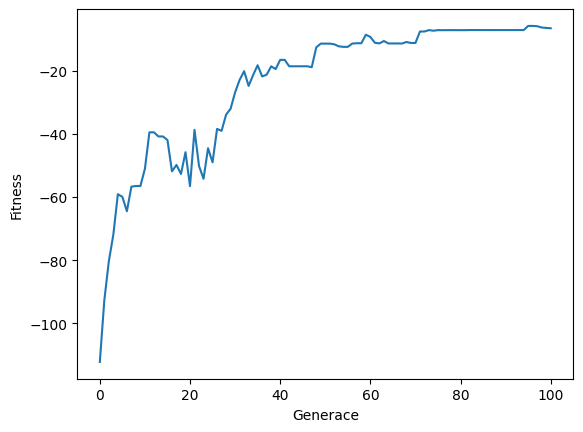

In [8]:
best, population, max_fitness = evolution(population_size=100,individual_size=10,max_generations=100)

print('best fitness: ', fitness(best))
print('best individual: ', best)


plt.plot(max_fitness)
plt.ylabel('Fitness')
plt.xlabel('Generace')


## Úkol na cvičení

V kódu výše je naprogramovaná nejjednodušší mutace -- nezatížená. Zkuste si napsat alespoň dva další druhy mutace z následujích možností a porovnat, jak se bude evoluční algoritmus chovat.
1. Zatížená mutace, kdy se k hodnotě v jedinci přičítá číslo z normalního rozdělení se střední hodnotou 0 a rozptylem sigma. Sigma se třeba navíc může během každých n generací postupně snižovat. 

2. Mutace s 1/5 pravidlem, která se používá hlavně u evolučních strategií a probíhá podobně jako zatížená mutace: přičítá k hodnotě číslo z náhodného rozdělení s 0 střední hodnotou a rozptylem sigma. Sigma se updatuje v každém kroku následovně: máme jedince a podíváme se, kolik je v populaci jedinců lepších než ten náš. Sigmu pak upravíme pomocí jednoduché rovnice: sigma = sigma * e^(počet_lepších_jedinců/počet_všech_jedinců-1/5).

3. Mutace z diferenciální evoluce, která vybere náhodně pro daného jedince dva další a složku po složce dělá rozdíl jejich hodnot a ten navíc vynásobí nějakou konstantou (třeba 0.8) a to pak přičte k hodnotám v původním jedinci. 

Můžete samozřejmě zkusit vymyslet i nějakou vlastní mutaci, nebo třeba zkusit vypnout mutaci nebo vypnout křížení a sledovat, co se bude s evolucí dít.




## Deap knihovna

Nyní si opět vyzkoušíme přepsat výše zmíněný problém minimalizace rastrigin funkce pomocí operátorů knihovny deap, abychom si lépe vyzkoušeli, jak se s ní pracuje a jak v ní tvořit svoje vlastní operátory, které se nám budou hodit příští hodinu u genetického programování (to už to bez něj totiž opravdu tak snadno nepůjde).

In [9]:
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

Pro jistotu si znovu definujeme vlastní funkce mutace, křížení a fitness funkci. Mutace bude opět nezatížená a křížení zůstane pomocí průměru dvou hodnot.

In [10]:
def rastring_function(individual):
    N = len(individual)
    A = 10
    value = A*N
    for i in range(0,len(individual)):
        value += individual[i]**2 - A*math.cos(2*math.pi*individual[i])
    return value,

def mutation_switch(individual,indpb):
    for i in range(0,len(individual)):
        if random.random() < indpb:
            individual[i] = np.random.uniform(-5.12, 5.12)
    return individual,

def crossover_mean(individual1, individual2, alpha=0.25):
    child1 = individual1
    child2 = individual2
    for i in range(0, len(individual1)):
        child1[i] = alpha*individual1[i] + (1-alpha)*individual2[i]
        child2[i] = (1-alpha)*individual1[i] + alpha*individual2[i]
    return child1, child2

Pak si zadefinujeme nový toolbox a přídáme do něj naše operátory. 

In [11]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # -1 protoze chci minimalizovat funkci
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

toolbox.register("attr_float", random.uniform,-5.12, 5.12)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=4)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", rastring_function)
toolbox.register("mate", crossover_mean)
toolbox.register("mutate", mutation_switch, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

Na závěr pustíme celou eveluci a můžeme sledovat, jak se nám hledání minima daří, nebo nedaří.

In [12]:
pop = toolbox.population(n=300)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.8, mutpb=0.2, ngen=100,
                               stats=stats, halloffame=hof, verbose=True)

gen	nevals	avg    	std   	min    	max    
0  	300   	72.7356	19.557	23.5162	127.384
1  	256   	55.625 	16.7361	6.03062	98.4765
2  	261   	48.1334	15.0284	6.03062	102.292
3  	254   	44.6325	14.6585	5.98477	86.0852
4  	254   	40.257 	16.3611	5.98477	89.6061
5  	274   	37.7087	14.2425	6.24339	84.1696
6  	267   	35.9897	13.7324	4.65541	77.456 
7  	252   	33.3461	14.7763	4.65541	76.2436
8  	245   	29.5205	14.6566	3.03622	77.6734
9  	259   	25.617 	15.6461	1.3557 	78.3374
10 	243   	19.1896	13.6196	1.35192	73.5564
11 	244   	14.1527	12.7397	0.829566	78.2368
12 	258   	8.77772	10.3729	0.446016	67.2393
13 	243   	4.63466	7.31682	0.400028	48.0454
14 	260   	2.29005	5.40869	0.225053	34.0513
15 	248   	2.34432	6.97601	0.210477	47.4882
16 	262   	2.03594	6.22503	0.229279	44.5115
17 	262   	1.98323	7.19593	0.237688	59.805 
18 	244   	2.1488 	7.30117	0.235749	54.3462
19 	246   	1.65633	6.32911	0.234007	53.9764
20 	253   	1.34799	4.91396	0.23253 	40.5211
21 	252   	1.61908	5.56921	0.232592	37.7468
22

## Domácí úkol - Batoh

Za domácí úkol budete mít vyřešit pomocí evolučního algoritmu problém batohu. Ten spočívá v tom, že máme batoh kapacity K a N předmětů, každý s cenou c<sub>i</sub> a objemem v<sub>i</sub> a chceme vybrat takové věci, abychom maximalizovali zisk a zároveň abychom nepřekročili kapacitu batohu. 

Vstupní data máte ve složce *domaci_ukol_data*. Obsahuje čtyři soubory s daty a dva s výsledky. Na první řádce souboru s daty je vždy počet předmětů a kapacita batohu oddělené mezerou, každý další následující řádek obsahuje cenu a objem předmětu taktéž oddělené mezerou. První dva soubory slouží pro snažší odladění evolučního algoritmu a obsahují i k sobě extra soubory s optimálním řešením. Na dalších dvou máte za úkol algoritmus pustit a výsledky na nich naměřené mi poslat. 

Napište tedy nějaký svůj evoluční algoritmus, který bude řešit problém batohu a pusťte ho na vstupních datech. Svůj kód, popis evolučního algoritmu (zvolené evoluční operátory, kódování jedince, atd.) a rozbor výsledků, včetně nejlepšího dosaženého skóre i s jejich odůvodněním mi pošlete emailem do stanoveného deadline.  Pro sepsání popisu vašeho evolučního algoritmu, parametrů evoluce, zvolené reprezentace jedince a rozboru výsledků použijte [tento template](https://github.com/kackamac/Prirodou-inspirovane-algoritmy/blob/master/04_spojita_reprezentace/DU1_evolucni_algoritmy.pdf).